In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np

import cartopy.crs as ccrs

import torch
import torch.nn as nn
import torch.utils.data as data
import torch_geometric
from torch.nn import Sequential as Seq, Linear, ReLU
from Networks import *
from Data_Functions import *
from matplotlib.animation import FuncAnimation
from Utils import *
from Subgrid_Funcs import *
import torch.distributed as dist

from Parallel import *
from Eval_Funcs import *
from torch.utils.data import Dataset, DataLoader
import os 
import sys
import random
os.environ['MKL_THREADING_LAYER'] = 'GNU'


In [ ]:
exp_num_in = "3"
exp_num_extra = "12"
exp_num_out = "2"


mse = torch.nn.MSELoss()
args = {}

region = "Gulf_Stream_Ext"  
depth_list = ["0","99","253"]
# 99 253 525
network = "U_net"

interval = 1

N_samples = 1400
N_val = 50
N_test = 400

factor = 10

hist = 0

lag = 1

lam = 100

steps = 4
Nb = 4

rand_seed = 1





if len(sys.argv) > 4:
    n_cond = int((len(sys.argv)-4)/2)

str_video = ""

try:
    for i in range(n_cond):
        if type(globals()[sys.argv[int(4 + i*2)]]) == str:
            temp = str(sys.argv[int(5 + i*2)])
            exec(sys.argv[int(4 + i*2)] +"= temp" )
            if sys.argv[int(4 + i*2)] == "network":
                continue            
            str_video += "_" + sys.argv[int(4 + i*2)] + "_" + sys.argv[int(5 + i*2)]
        elif type(globals()[sys.argv[int(4 + i*2)]]) == int:
            exec(sys.argv[int(4 + i*2)] +"=" + "int(" + sys.argv[int(5 + i*2)] +")" )
            str_video += "_" + sys.argv[int(4 + i*2)] + "_" + sys.argv[int(5 + i*2)]
    print(str_video)
except:
    print("no cond")

str_video += "no_KE"    
    
torch.manual_seed(rand_seed)
random.seed(rand_seed)
np.random.seed(rand_seed)

    
args["Nb"] = Nb    
args["region"] = region
args["network"] = network
args["interval"] = interval
args["N_samples"] = N_samples
args["N_val"] = N_val
args["N_test"] = N_test
args["factor"] = factor
args["hist"] = hist
args["lag"] = lag
args["steps"] = steps
args["str_video"] = str_video

    
if region == "Kuroshio":
    lat = [15,41]
    lon = [-215, -185]
elif region == "Kuroshio_Ext":
    lat = [5,50]
    lon = [-250, -175]      
elif region == "Gulf_Stream":
    lat = [25, 50]
    lon = [-70,-35]
elif region == "Gulf_Stream_Ext":
    lat = [27, 50]
    lon = [-82,-35]       
elif region == "Tropics":
    lat = [-5,25]
    lon = [-95,-65]  
elif region == "Tropics_Ext":
    lat = [-5,25]
    lon = [-115,-45]     
elif region == "South_America":
    lat = [-60, -30]
    lon = [-70,-35] 
elif region == "Africa":
    lat = [-50, -20]
    lon = [5,45] 
elif region == "Quiescent":
    lat = [-42.5, -17.5]
    lon = [-155,-120] 
elif region == "Quiescent_Ext":
    lat = [-55, -10]
    lon = [-170,-110]            
elif region == "Pacific":
    lat = [-35, 35]
    lon = [-230,-80]     
elif region == "Indian":
    lat = [-30, 28]
    lon = [30,79]    
elif region == "Africa_Ext":
    lat = [-55, -15]
    lon = [-5,55]     
    
    
s_train = lag*hist
e_train = s_train + N_samples*interval
e_test = e_train + interval*N_val



device = "cpu"


inpt_dict = {"1":["um","vm"],"2":["um","vm","ur","vr"],"3":["um","vm","Tm"],
            "4":["um","vm","ur","vr","Tm","Tr"],"5":["ur","vr"],"6":["ur","vr","Tr"],
            "7":["Tm"],"8":["Tm","Tr"],"9":["u","v"],"10":["u","v","T"],
            "11":["tau_u","tau_v"],"12":["tau_u","tau_v","t_ref"]} 
extra_dict = {"1":["ur","vr"],"2":["ur","vr","Tm"],
            "3":["Tm"],"4":["ur","vr","Tm","Tr"],"5":[],"6":["um","vm"],
             "7":["um","vm","Tm"], "8": ["um","vm","Tm","Tr"],
              "9":["ur","vr","tau_u","tau_v"],"10":["tau_u","tau_v"],
              "11":["ur","vr","Tr"],"12":["tau_u","tau_v","t_ref"],
             "13":["ur","vr","Tr","tau_u","tau_v","t_ref"]} 
out_dict = {"1":["um","vm"],"2":["um","vm","Tm"],"3":["ur","vr"],
           "4":["ur","vr","Tr"],"5":["u","v"],"6":["u","v","T"]}

grids = xr.open_dataset('/scratch/zanna/data/CM2_grids/Grid_cm25_Vertices.nc')

if region == "global_25":
    grids = xr.open_dataset('/scratch/zanna/data/CM2_grids/Grid_cm25_Vertices.nc')

elif "global" in region:
    grids = coarse_grid(grids,factor)

else:
    grids = grids.sel({"yu_ocean":slice(lat[0],lat[1]),"xu_ocean":slice(lon[0],lon[1])})


area = torch.from_numpy(grids["area_C"].to_numpy()).to(device=device)

dx = grids["dxu"].to_numpy()
dy = grids["dyu"].to_numpy()
dy = dy/dx.max()
dx = torch.from_numpy(dx/dx.max()).type(torch.float32)
dy = torch.from_numpy(dy).type(torch.float32)  


inputs_str = inpt_dict[exp_num_in]
extra_in_str = extra_dict[exp_num_extra]
outputs_str = out_dict[exp_num_out]

str_in = "".join([i + "_" for i in inputs_str])
str_ext = "".join([i + "_" for i in extra_in_str])
str_out = "".join([i + "_" for i in outputs_str])

print("inputs: " + str_in)
print("extra inputs: " + str_ext)
print("outputs: " + str_out)

N_atm = len(extra_in_str)
N_var = len(inputs_str)
N_in = (len(inputs_str)*len(depth_list))
N_extra = N_atm + N_in
N_out = int(len(outputs_str)*len(depth_list))

num_in = int((hist+1)*N_in + N_extra)

input_depth = []
output_depth = []

for depth in depth_list:
    for i in range(len(inputs_str)):
        input_depth.append(inputs_str[i]+"_"+depth)
    for i in range(len(outputs_str)):
        output_depth.append(outputs_str[i]+"_"+depth)

norm_vals = get_norms(region,input_depth,extra_in_str,output_depth)

inputs, extra_in, outputs = gen_data_025_lateral_3D(inputs_str,extra_in_str,outputs_str,depth_list,lag,lat,lon,Nb,run_type="")
inputs_2, extra_in_2, outputs_2 = gen_data_025_lateral_3D(inputs_str,extra_in_str,outputs_str,depth_list,lag,lat,lon,Nb,run_type="2x")

wet_list = []
wet_lap_list = []
for i in range(len(depth_list)):
    wet = xr.zeros_like(inputs[0][0])
    # inputs[0][0,12,12] = np.nan
    for data in inputs[N_var*i:N_var*(i+1)]:
        wet +=np.isnan(data[0])
    wet_nan = xr.where(wet!=0,np.nan,1).to_numpy()    
    wet = np.isnan(xr.where(wet==0,np.nan,0))
    wet = np.nan_to_num(wet.to_numpy())
    wet = torch.from_numpy(wet).type(torch.float32).to(device="cpu")

    wet_lap = compute_laplacian_wet(wet_nan,Nb)
    wet_lap = xr.where(wet_lap==0,1,np.nan)
    wet_lap = np.nan_to_num(wet_lap)
    wet_lap = torch.from_numpy(wet_lap).type(torch.float32).to(device=device)
    wet_list.append(wet)
    wet_lap_list.append(wet_lap)

args["s_train"] = s_train
args["e_train"] = e_train
args["e_test"] = e_test


args["inputs"] = [inputs, inputs_2]
args["extra_in"] = [extra_in, extra_in_2]
args["outputs"] = [outputs, outputs_2]


args["wet"] = wet_list
args["dx"] = dx
args["dy"] = dy
args["wet_lap"] = wet_lap
args["area"] = area
args["N_extra"] = N_extra
args["N_in"] = N_in
args["N_out"] = N_out
args["N_var"] = N_var
args["N_atm"] = N_atm
args["num_in"] = num_in
args["str_in"] = str_in
args["str_ext"] = str_ext 
args["str_out"] = str_out
args["norm_vals"] = norm_vals

no cond
inputs: um_vm_Tm_
extra inputs: tau_u_tau_v_t_ref_
outputs: um_vm_Tm_


/scratch/as15415/Emulation/Data_Functions.py:895: UserWarning: rename 'lat' to 'yu_ocean' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data_atmos = data_atmos.rename({"lat":"yu_ocean","lon":"xu_ocean"})
/scratch/as15415/Emulation/Data_Functions.py:895: UserWarning: rename 'lon' to 'xu_ocean' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data_atmos = data_atmos.rename({"lat":"yu_ocean","lon":"xu_ocean"})
/scratch/as15415/Emulation/Data_Functions.py:895: UserWarning: rename 'lat' to 'yu_ocean' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data_atmos = data_atmos.rename({"lat":"yu_ocean","lon":"xu_ocean"})
/scratch/as15415/Emulation/Data_Functions.py:895: UserWarning: rename 'lon' to 'xu_ocean' does not create an index anymore. Try using swap_dims i

In [3]:
args["lateral"] = True
os.environ['MASTER_ADDR'] = 'localhost' 
os.environ['MASTER_PORT'] = str(np.random.randint(1000,1200)) 


# data_in_train = []
# data_out_train = []

# for i in range(steps):
#     data_in_train.append(gen_data_in(i,s_train,e_train,interval,lag,hist,inputs,extra_in))
#     data_out_train.append(gen_data_out(i,s_train,e_train,lag,interval,outputs))

    
# train_data = data_CNN_steps_3D(data_in_train,data_out_train,steps,wet_list,N_atm,Nb,device=device,norms=norm_vals,N_vars=N_var)       

data_in_val = gen_data_in(0,e_train,e_test,interval,lag,hist,inputs,extra_in)  
data_out_val = gen_data_out(0,e_train,e_test,lag,interval,outputs)

val_data = data_CNN_Lateral(data_in_val,data_out_val,wet_list,N_atm,Nb,device=device,N_vars=N_var)     

In [ ]:
inputs, extra_in, outputs = gen_data_025_lateral_3D(inputs_str,extra_in_str,outputs_str,depth_list,lag,lat,lon,Nb,run_type="2x")

os.environ['MASTER_ADDR'] = 'localhost' 
os.environ['MASTER_PORT'] = '1324' 


data_in_train = []
data_out_train = []

for i in range(steps):
    data_in_train.append(gen_data_in(i,s_train,e_train,interval,lag,hist,inputs,extra_in))
    data_out_train.append(gen_data_out(i,s_train,e_train,lag,interval,outputs))

    
train_data_temp = data_CNN_steps_Lateral(data_in_train,data_out_train,steps,wet,N_atm,Nb,device=device,norms=norm_vals)       

for i in range(len(train_data_temp.input)):
    train_data.input[i] = torch.concat((train_data.input[i],train_data_temp.input[i]),dim=0)
    train_data.output[i] = torch.concat((train_data.output[i],train_data_temp.output[i]),dim=0)
train_data.size = train_data.size + train_data_temp.size


In [4]:
args ["load"] = True

# args["train_data"] = train_data
args["val_data"] = val_data
args["save_model"] = True
args["World_Size"] = int(torch.cuda.device_count())
args["epochs"] = 10
args["batch_size"] = 6
args["lateral"] = True
args["loss_type"] = "Enstrophy"
# lam = lam/1000
args["lam"] = 0
# args["step_weights"] = [[1],[.2,.8],[.2,.2,.6],[.1,.1,.2,.8],[.1,.1,.1,.2,.7],[.1,.1,.1,.1,.2,.7],[.1,.1,.1,.1,.1,.2,.7]]
args["step_weights"] = [[1],[1,1],[1,1,1],[1,1,1,1],[1,1,1,1,1],[.1,.1,.1,.1,.2,.7],[.1,.1,.1,.1,.1,.2,.7]]

args["step_lrs"] = [1e-4,5e-5,1e-5,1e-5,5e-6,5e-6,5e-6]
args["step_lrs"] = [i*1e-1 for i in args["step_lrs"]]

if __name__ == '__main__':
    torch.multiprocessing.spawn(worker_3D, nprocs=args["World_Size"], args=(args,))   

9 12
9 12
9 12
9 12
9 12
9 12
9 12
9 12
Epoch =  1, Validation Loss = 0.260
Epoch =  2, Validation Loss = 0.227
Epoch =  3, Validation Loss = 0.226
Epoch =  4, Validation Loss = 0.215
Epoch =  5, Validation Loss = 0.211
Epoch =  6, Validation Loss = 0.216
Epoch =  7, Validation Loss = 0.205
Epoch =  8, Validation Loss = 0.208
Epoch =  9, Validation Loss = 0.211
Epoch = 10, Validation Loss = 0.200
Epoch =  1, Validation Loss = 0.208
Epoch =  2, Validation Loss = 0.201
Epoch =  3, Validation Loss = 0.203
Epoch =  4, Validation Loss = 0.218
Epoch =  5, Validation Loss = 0.209
Epoch =  6, Validation Loss = 0.205
Epoch =  7, Validation Loss = 0.197
Epoch =  8, Validation Loss = 0.200
Epoch =  9, Validation Loss = 0.193
Epoch = 10, Validation Loss = 0.190
Epoch =  1, Validation Loss = 0.193
Epoch =  2, Validation Loss = 0.201
Epoch =  3, Validation Loss = 0.204
Epoch =  4, Validation Loss = 0.202
Epoch =  5, Validation Loss = 0.207
Epoch =  6, Validation Loss = 0.198
Epoch =  7, Validation L

In [5]:
1

1

In [7]:
inputs, extra_in, outputs = gen_data_025_lateral_3D(inputs_str,extra_in_str,outputs_str,depth_list,lag,lat,lon,Nb,run_type="4x")


data_in_test = gen_data_in_test(0,e_test,N_test,lag,hist,inputs,extra_in)

data_out_test = gen_data_out_test(0,e_test,N_test,lag,hist,outputs)

test_data = data_CNN_Lateral(data_in_test,data_out_test,wet_list,N_atm,Nb,device="cuda",norms=norm_vals,N_vars=N_var) 

# time_test = time_vec[e_test:(e_test+lag*N_test)]

mean_out = test_data.norm_vals['m_out']  
std_out = test_data.norm_vals['s_out']  

/scratch/as15415/Emulation/Data_Functions.py:895: UserWarning: rename 'lat' to 'yu_ocean' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data_atmos = data_atmos.rename({"lat":"yu_ocean","lon":"xu_ocean"})
/scratch/as15415/Emulation/Data_Functions.py:895: UserWarning: rename 'lon' to 'xu_ocean' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data_atmos = data_atmos.rename({"lat":"yu_ocean","lon":"xu_ocean"})


In [8]:

wet_cuda = [args["wet"][i].to("cuda") for i in range(len(args["wet"]))]

model = U_net_3D([args["num_in"],64,128,256,512],args["N_out"],wet_cuda,args["N_var"])
model.to(device="cuda");
model.load_state_dict(torch.load("/scratch/as15415/Emulation/Networks/U_net_3D_Gulf_Stream_Ext_in_um_vm_Tm_ext_tau_u_tau_v_t_ref__outum_vm_Tm_N_train_1400no_KE.pt",map_location=torch.device("cpu")))

model_pred = recur_pred_lateral(340,test_data,model,hist,N_in,N_extra,Nb)





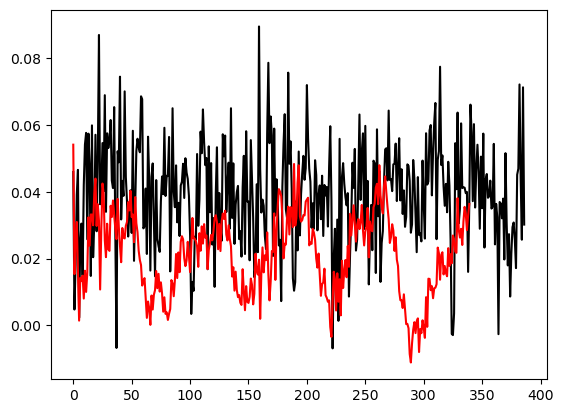

In [11]:
ind = 0
plt.plot((((test_data[:][1][:,ind]*std_out[ind]+mean_out[ind]).cpu())).mean(axis=(1,2)),"k")
plt.plot((model_pred[:,:,:,ind]).mean(axis=(1,2)),"r")


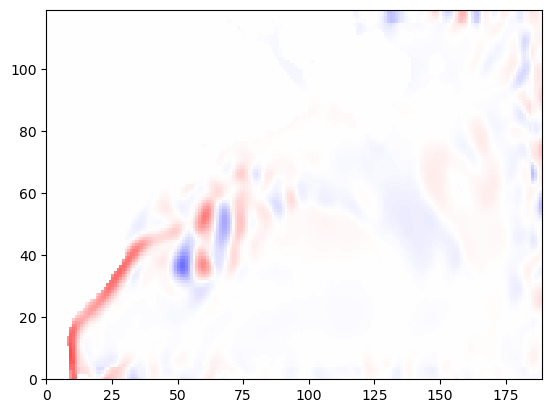

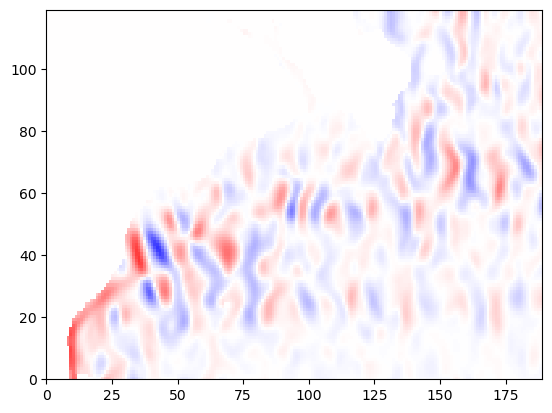

In [12]:
T_plot = 340
ind_plot = 7
vmin = -1
vmax = 1

# vmin = 0
# vmax = 30

plt.pcolor(model_pred[T_plot-1,:,:,ind_plot],vmin=vmin,vmax=vmax,cmap="bwr")
plt.figure()
plt.pcolor(test_data[T_plot-1][1][ind_plot].cpu()*std_out[ind_plot]+mean_out[ind_plot],vmin=vmin,vmax=vmax,cmap="bwr")

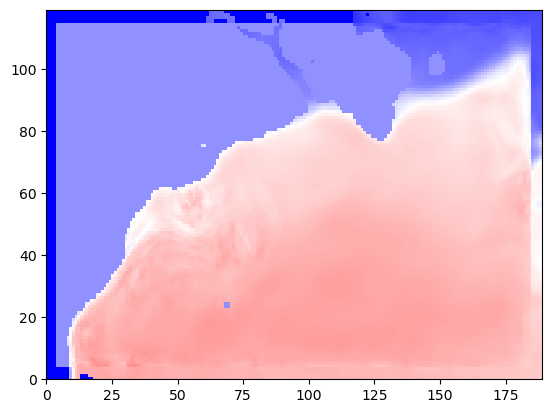

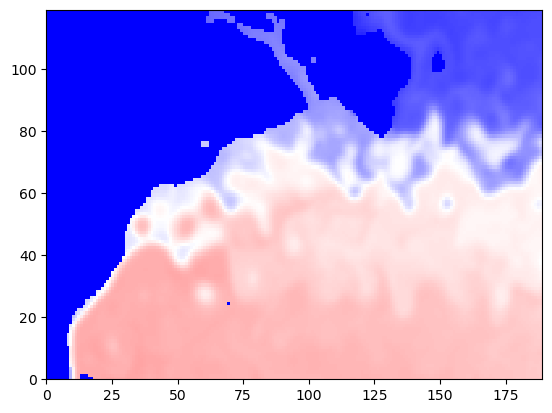

In [13]:
T_plot = 300
ind_plot = 8
# vmin = -1
# vmax = 1

vmin = 0
vmax = 30

plt.pcolor(model_pred[T_plot-1,:,:,ind_plot],vmin=vmin,vmax=vmax,cmap="bwr")
plt.figure()
plt.pcolor(test_data[T_plot-1][1][ind_plot].cpu()*std_out[ind_plot]+mean_out[ind_plot],vmin=vmin,vmax=vmax,cmap="bwr")

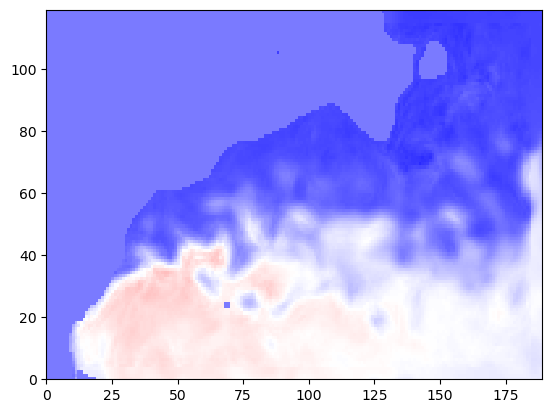

In [78]:
plt.pcolor(model_pred[349,:,:,2],vmin=0,vmax=30,cmap="bwr")

In [28]:
lap_test = compute_laplacian(model_pred[0:10,:,:,2],None,Nb,np.array(wet_lap))

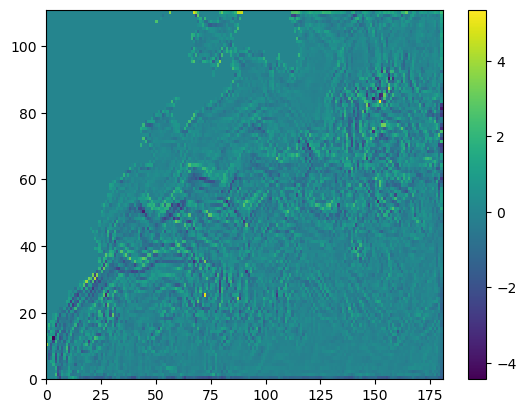

In [29]:
plt.pcolor(lap_test[3])
plt.colorbar()

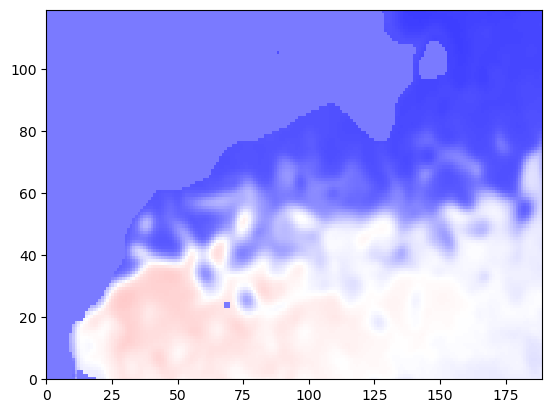

In [79]:
plt.pcolor(test_data[349][1][2].cpu()*std_out[2]+mean_out[2],vmin=0,vmax=30,cmap="bwr")

In [31]:
lap_test = compute_laplacian(test_data[:10][1][:,2].cpu(),None,Nb,np.array(wet_lap))

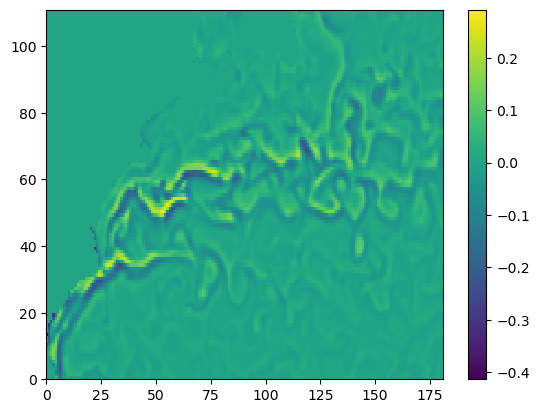

In [32]:
plt.pcolor(lap_test[3])
plt.colorbar()